# Unamortised VAE test

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../experiments/")
import base_vae_hardem

In [3]:
import os

os.environ["TPU_CHIPS_PER_HOST_BOUNDS"] = "1,1,1"
os.environ["TPU_HOST_BOUNDS"] = "1,1,1"
os.environ["TPU_VISIBLE_DEVICES"] = "0"

In [4]:
import jax
import hlax
import tomli
import distrax
import pandas as pd
import seaborn as sns
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt

In [5]:
%config InlineBackend.figure_format = "retina"

In [6]:
def build_mll_summary(res, procedure):
    df_mll = pd.DataFrame(res["test"]).melt(var_name="episode", value_name="mll")
    df_mll["procedure"] = procedure

    df_times = pd.DataFrame.from_dict({"times": res["train"]["times"]}, orient="index").T
    df_mll = pd.merge(df_mll, df_times, left_on="episode", right_index=True)
    return df_mll

## Loss functions

In [8]:
def iwae_bern(key, params, apply_fn, X_batch):
    """
    Importance-weighted marginal log-likelihood for
    a Bernoulli decoder
    """
    batch_size = len(X_batch)

    # keys = jax.random.split(key, batch_size)
    # encode_decode = jax.vmap(apply_fn, (None, 0, 0))
    # encode_decode = encode_decode(params, X_batch, keys)
    encode_decode = apply_fn(params, X_batch, key)
    z, (mean_z, logvar_z), logit_mean_x = encode_decode
    _, num_is_samples, dim_latent = z.shape

    std_z = jnp.exp(logvar_z / 2)
    
    dist_prior = distrax.MultivariateNormalDiag(jnp.zeros(dim_latent),
                                                jnp.ones(dim_latent))
    dist_decoder = distrax.Bernoulli(logits=logit_mean_x)
    dist_posterior = distrax.Normal(mean_z[None, ...], std_z[None, ...])

    log_prob_z_prior = dist_prior.log_prob(z)
    log_prob_x = dist_decoder.log_prob(X_batch).sum(axis=-1)
    log_prob_z_post = dist_posterior.log_prob(z).sum(axis=-1)

    log_prob = log_prob_z_prior + log_prob_x - log_prob_z_post

    # negative Importance-weighted marginal log-likelihood
    niwmll = -jax.nn.logsumexp(log_prob, axis=-1, b=1/num_is_samples).mean()
    return niwmll



def hard_nmll_bern(params, z_batch, X_batch, model):
    """
    Loss function
    -------------

    Negative Marginal log-likelihood for hard EM
    assuming an isotropic Gaussian prior with zero mean
    and a decoder with a diagonal covariance matrix

    Parameters
    ----------
    params: pytree
        Parameters of the decoder model, i.e.,
        model.apply(params, z_batch) = X_batch (approx)
    z_batch: jnp.ndarray
        Batch of latent variables
    X_batch: jnp.ndarray
        Batch of observations
    model: flax.nn.Module
        Decoder model (input z -> output x)
    """
    dim_latent = model.dim_latent

    logit_mean_x = model.apply(params, z_batch)

    dist_prior = distrax.MultivariateNormalDiag(jnp.zeros(dim_latent), jnp.ones(dim_latent))
    dist_decoder = distrax.Bernoulli(logits=logit_mean_x)

    log_prob_z_prior = dist_prior.log_prob(z_batch)
    log_prob_x = dist_decoder.log_prob(X_batch).sum(axis=-1)

    log_prob = log_prob_z_prior + log_prob_x

    return -log_prob.mean()


def neg_iwmll_bern(key, params_encoder, params_decoder, observation,
              encoder, decoder, num_is_samples=10):
    """
    Importance-weighted marginal log-likelihood for an unamortised, uncoditional
    gaussian encoder.
    """
    latent_samples, (mu_z, std_z) = encoder.apply(
        params_encoder, key, num_samples=num_is_samples
    )

    _, dim_latent = latent_samples.shape
    # log p(x|z)
    logit_mean_x = decoder.apply(params_decoder, latent_samples)
    log_px_cond = distrax.Bernoulli(logits=logit_mean_x).log_prob(observation).sum(axis=-1)

    # log p(z)
    mu_z_init, std_z_init = jnp.zeros(dim_latent), jnp.ones(dim_latent)
    log_pz = distrax.MultivariateNormalDiag(mu_z_init, std_z_init).log_prob(latent_samples)

    # log q(z)
    log_qz = distrax.MultivariateNormalDiag(mu_z, std_z).log_prob(latent_samples)

    # Importance-weighted marginal log-likelihood
    log_prob = log_pz + log_px_cond - log_qz
    niwmll = -jax.nn.logsumexp(log_prob, axis=-1, b=1/num_is_samples)
    return niwmll

## Models

In [31]:
from typing import Callable

class Decoder(nn.Module):
    """
    For the generative model
    p(x,z) = p(x|z) * p(z)
    """
    dim_full: int
    dim_latent: int = 20
    
    def setup(self):
        self.logit = nn.Dense(self.dim_full, use_bias=True, name="mean")
    
    @nn.compact
    def __call__(self, z):
        x = nn.Dense(200)(z)
        x = nn.elu(x)
        x = nn.Dense(100)(x)
        x = nn.elu(x)
        x = nn.Dense(50)(x)
        x = nn.elu(x)
        logit_x = self.logit(x)
        return logit_x


class Encoder(nn.Module):
    """
    two-layered encoder
    """
    latent_dim: int
    n_hidden: int = 100
    
    @nn.compact
    def __call__(self, x):
        z = nn.Dense(self.n_hidden)(x)
        z = nn.elu(z)
        z = nn.Dense(self.n_hidden)(z)
        z = nn.elu(z)
        mean_z = nn.Dense(self.latent_dim)(z)
        logvar_z = nn.Dense(self.latent_dim)(z)
        return mean_z, logvar_z
    
    
class GaussEncoder(nn.Module):
    dim_latent: int
    normal_init: Callable = nn.initializers.normal()

    def setup(self):
        self.mu = self.param("mu", self.normal_init, (self.dim_latent,))
        self.logvar_diag = self.param("logvar_diag", self.normal_init, (self.dim_latent,))

    def sample_proposal(self, key, num_samples):
        std = jnp.exp(self.logvar_diag / 2)
        eps = jax.random.normal(key, (num_samples, self.dim_latent))
        z = self.mu[None, ...] + jnp.einsum("d,...d->...d", std, eps)
        return z

    def __call__(self, _):
        """
        Input x (_) is a dummy variable
        """
        return self.mu, self.logvar_diag

## Setup

In [9]:
batch_size = 200
key = jax.random.PRNGKey(314)
warmup, test = hlax.datasets.load_fashion_mnist(n_train=1000, n_test=100, normalize=False)
X_warmup = warmup[0].round()
X_test = test[0].round()

In [12]:
dim_latent = 50
num_obs, *dim_obs = X_warmup.shape

In [13]:
path_config = "../experiments/configs/fmnist-conv01.toml"
with open(path_config, "rb") as f:
    config_str = f.read().decode("utf-8")
    config = tomli.loads(config_str)

print(config_str)

# TOML file for a fashion mnist dataset
[setup]
dim_latent = 50

[train]
    num_obs = 10_000
    num_epochs = 3000
    batch_size = 200
    eval_epochs = [2, 10, 100, 250, 500, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2500, 3000]
    learning_rate = 1e-6 # For VAE and HardEM

    [train.vae]
        num_is_samples = 10
    [train.hard_em]
        num_its_latent = 10 # E-step
        num_its_params = 5 # M-step

[test]
    num_obs = 1000
    num_epochs = 500
    learning_rate = 1e-6
    num_is_samples = 10


In [14]:
model_decoder = Decoder(28 ** 2, dim_latent)
model_encoder_test = hlax.models.GaussEncoder(dim_latent)
config_test = base_vae_hardem.load_test_config(config, model_encoder_test, model_decoder)

grad_neg_iwmll_encoder = jax.value_and_grad(neg_iwmll_bern, argnums=1)
vmap_neg_iwmll = jax.vmap(neg_iwmll_bern, (0, 0, None, 0, None, None, None))

## Benchmark models

### VAE

In [15]:
model_vae = hlax.models.VAEBern(dim_latent, dim_obs[0], Encoder, Decoder)
config_vae = hlax.vae.load_config(config, model_vae)

res_vae = base_vae_hardem.train_test(
    key,
    X_warmup,
    X_test,
    config_vae,
    config_test,
    iwae_bern,
    vmap_neg_iwmll,
    grad_neg_iwmll_encoder,
    hlax.vae.train_checkpoints
)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

### Hard-EM LVM

In [16]:
# Decoder model
model_hem = Decoder(28 ** 2, dim_latent)
config_hem = hlax.hard_em_lvm.load_config(config, model_hem)

res_hem = base_vae_hardem.train_test(
    key,
    X_warmup,
    X_test,
    config_hem,
    config_test,
    hard_nmll_bern,
    vmap_neg_iwmll,
    grad_neg_iwmll_encoder,
    hlax.hard_em_lvm.train_checkpoints
)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

### Umamortised VAE

In [32]:
model_uvae = hlax.models.UnamortisedVAEBern(dim_latent, dim_obs[0], GaussEncoder, Decoder)
config_uvae = hlax.unamortised.load_config(config, model_uvae)

res_uvae = base_vae_hardem.train_test(
    key,
    X_warmup,
    X_test,
    config_uvae,
    config_test,
    iwae_bern,
    vmap_neg_iwmll,
    grad_neg_iwmll_encoder,
    hlax.unamortised.train_checkpoints
)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

## Results

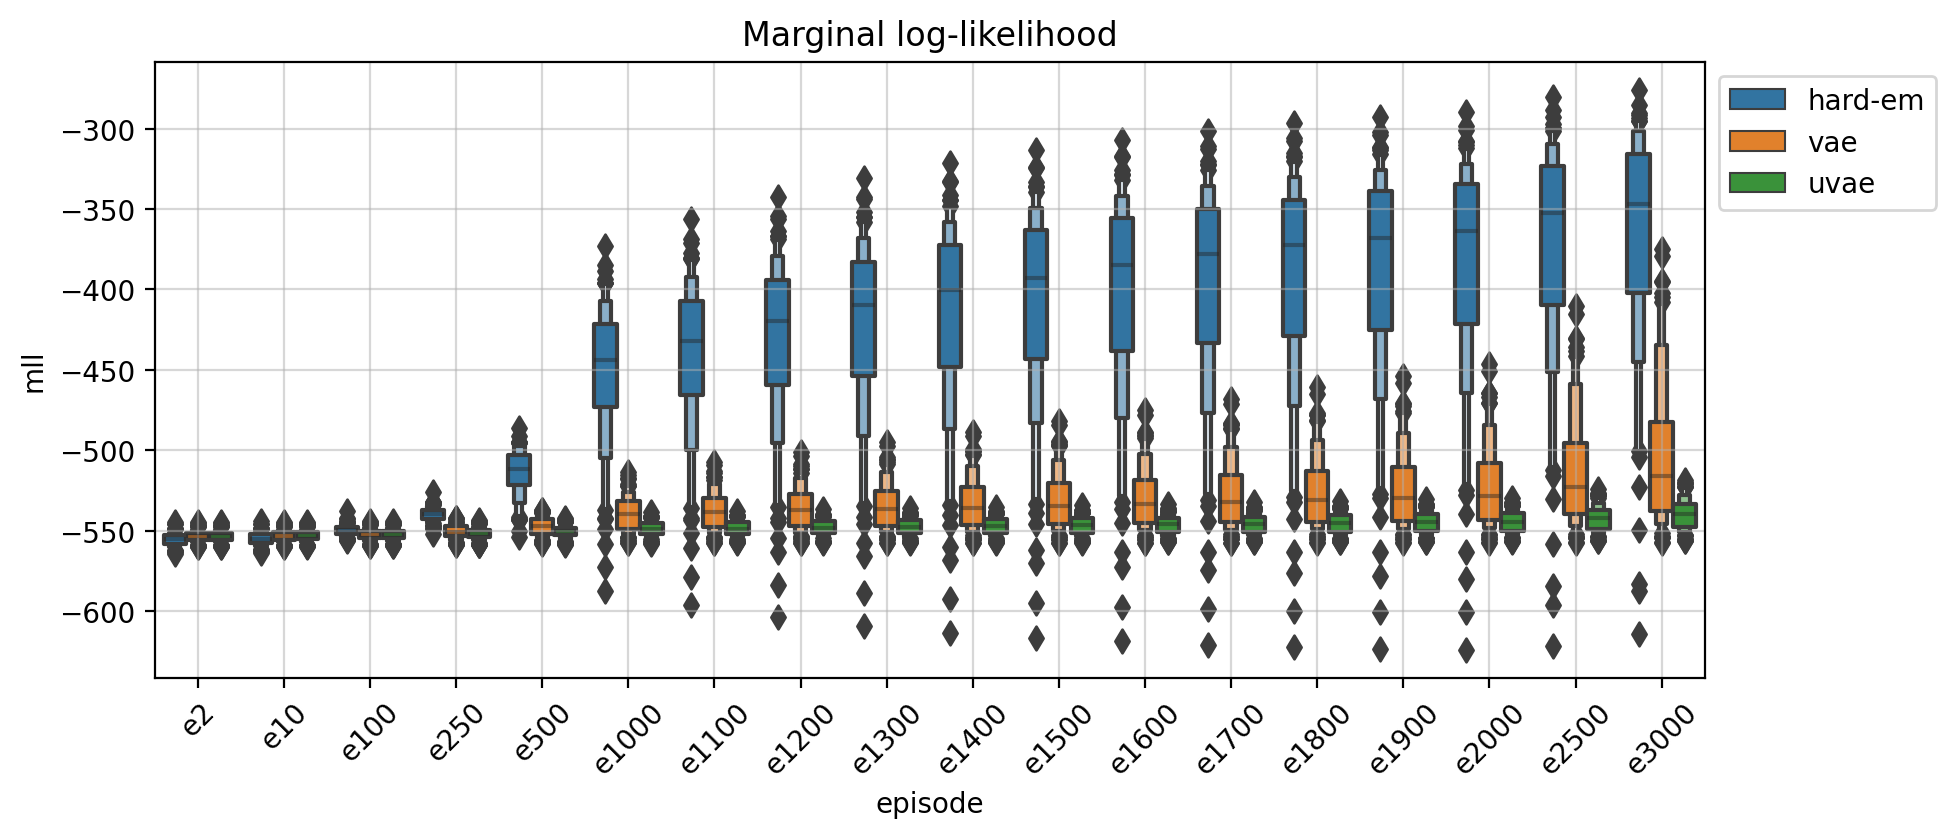

In [33]:
df_uvae = build_mll_summary(res_uvae, "uvae")
df_vae = build_mll_summary(res_vae, "vae")
df_hem = build_mll_summary(res_hem, "hard-em")

df_all = pd.concat([df_hem, df_vae, df_uvae])
fig, ax = plt.subplots(figsize=(10, 4))
sns.boxenplot(x="episode", y="mll", hue="procedure", data=df_all)
plt.title("Marginal log-likelihood")
plt.xticks(rotation=45)
plt.grid(alpha=0.5)
plt.legend(bbox_to_anchor=(1.0, 1.0))

**Q**: We may consider using E/M type training for the unamortised VAE.